word2vec is a technique for encoding words (or other tokens in a sequence) into high dimensional vectors. These vectors can be used for similarity lookups and arithmetic operations. The word2vec algorithm is implemented by [gensim](https://radimrehurek.com/gensim/).

In [1]:
from gensim.models import Word2Vec

Instead of spending days training our own model on lots of text, we can load a pre-trained model. This one was [trained by Google](https://code.google.com/p/word2vec/) on three million unique words and phrases in news articles. Each word is embedded in a 300-dimensional space. It's a 3.6GB file (compressed to 1.6GB) and can take almost two minutes to load this model from disk.

In [2]:
model = Word2Vec.load_word2vec_format('../../models/word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True)

We can look up the vector for a single word like this:

In [3]:
vector = model['Japan']
print(vector.shape)

(300,)


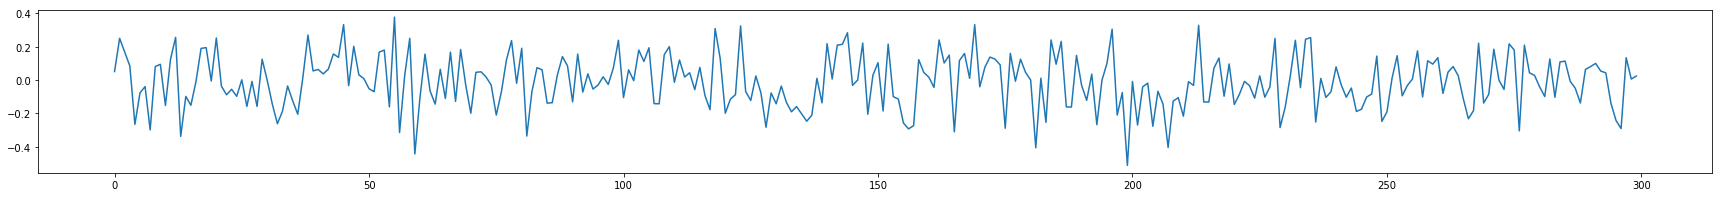

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[30, 3])
plt.plot(vector)
plt.show()

In [5]:
print vector

[  5.07812500e-02   2.50000000e-01   1.66992188e-01   8.44726562e-02
  -2.65625000e-01  -7.71484375e-02  -3.95507812e-02  -2.98828125e-01
   8.05664062e-02   9.42382812e-02  -1.52343750e-01   1.25000000e-01
   2.55859375e-01  -3.37890625e-01  -9.81445312e-02  -1.51367188e-01
  -9.27734375e-03   1.89453125e-01   1.94335938e-01  -5.88989258e-03
   2.51953125e-01  -3.66210938e-02  -8.83789062e-02  -5.54199219e-02
  -9.76562500e-02   1.38854980e-03  -1.58203125e-01  -8.54492188e-03
  -1.58203125e-01   1.24511719e-01  -2.04467773e-03  -1.44531250e-01
  -2.61718750e-01  -1.86523438e-01  -3.58886719e-02  -1.24511719e-01
  -2.05078125e-01   1.54418945e-02   2.69531250e-01   5.44433594e-02
   6.34765625e-02   3.68652344e-02   6.49414062e-02   1.56250000e-01
   1.35742188e-01   3.32031250e-01  -3.39355469e-02   2.02148438e-01
   3.11279297e-02   7.87353516e-03  -5.20019531e-02  -7.03125000e-02
   1.66992188e-01   1.79687500e-01  -1.61132812e-01   3.76953125e-01
  -3.14453125e-01   2.40478516e-02

If we sort the dimensions by one vector, we can see the similar words follow it, and the dissimilar one does not.

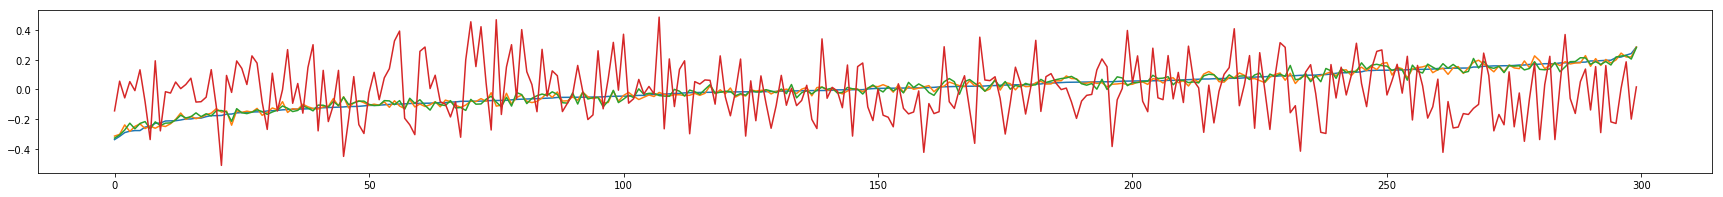

In [6]:
plt.figure(figsize=[30, 3])
plt.plot(sorted(zip(model['Tuesday'], model['Wednesday'], model['Thursday'], model['teapot'])))
plt.show()

Using these vectors we can make metaphors, such as "What is the Berlin of Japan (instead of Germany)?" also written:
`Berlin + Japan - Germany`:

In [7]:
model.most_similar(positive=['Berlin', 'Japan'], negative=['Germany'])

[(u'Tokyo', 0.7485348582267761),
 (u'Toyko', 0.6140641570091248),
 (u'Japanese', 0.5829421281814575),
 (u'Seoul', 0.5801318883895874),
 (u'Fukuoka', 0.5745269656181335),
 (u'Nagoya', 0.5597074031829834),
 (u'Aomori', 0.5552585124969482),
 (u'Osaka', 0.5507832765579224),
 (u'Tsuruoka', 0.5430541038513184),
 (u'Ishihara', 0.5422928333282471)]

Or, "What is a queen as a man (instead of a woman)?" Notice that the words are case sensitive.
`queen + man - woman`

In [8]:
model.most_similar(positive=['queen', 'man'], negative=['woman'])

[(u'king', 0.6958590149879456),
 (u'kings', 0.5950952768325806),
 (u'queens', 0.5838501453399658),
 (u'monarch', 0.5398427248001099),
 (u'prince', 0.5223615169525146),
 (u'princess', 0.5175285935401917),
 (u'princes', 0.49844634532928467),
 (u'royal', 0.4924592971801758),
 (u'NYC_anglophiles_aflutter', 0.4859851002693176),
 (u'Eugene_Ionesco_absurdist_comedy', 0.4784241020679474)]

We can look for the most similar words in the 1000 most common words.

In [9]:
limit = 1000
limited = model.index2word[:limit]
matches = [(model.most_similar(positive=[word], topn=1, restrict_vocab=limit)[0], word) for word in limited]
sorted([(x[1],x[0],y) for x,y in matches], reverse=True)[:200]

[(0.9816684722900391, u'Wednesday', u'Thursday'),
 (0.9816684722900391, u'Thursday', u'Wednesday'),
 (0.9792295098304749, u'Wednesday', u'Tuesday'),
 (0.9720569849014282, u'Tuesday', u'Monday'),
 (0.9703434705734253, u'three', u'four'),
 (0.9703434705734253, u'four', u'three'),
 (0.9675939679145813, u'January', u'February'),
 (0.9675938487052917, u'February', u'January'),
 (0.9635934829711914, u'February', u'October'),
 (0.9619013667106628, u'eight', u'seven'),
 (0.9619013071060181, u'seven', u'eight'),
 (0.9616837501525879, u'May', u'April'),
 (0.9616837501525879, u'April', u'May'),
 (0.9606297612190247, u'four', u'five'),
 (0.9601354598999023, u'April', u'March'),
 (0.957943856716156, u'October', u'August'),
 (0.9557317495346069, u'June', u'July'),
 (0.9557317495346069, u'July', u'June'),
 (0.9544944763183594, u'October', u'September'),
 (0.9543241262435913, u'3', u'2'),
 (0.9543240070343018, u'2', u'3'),
 (0.9529386758804321, u'6', u'5'),
 (0.9529386758804321, u'5', u'6'),
 (0.95256

gensim also provides interfaces for how similar two words are.

In [10]:
model.similarity('computer', 'calculator')

0.33398881966589217

In [11]:
model.similarity('computer', 'rain')

0.060617714645925518

Or which words don't belong, like "[Which one of these things is not like the other](https://www.youtube.com/watch?v=gCxrkl2igGY)".

In [12]:
model.doesnt_match('hammer shoe handsaw pliers'.split()) # try "saw" instead

'shoe'

In [13]:
model.doesnt_match("sweet sour salty wet".split()) # add umami

'wet'

As you work with word2vec you will notice that opposites are more similar to each other than they are to very different things:

In [14]:
model.similarity('hot', 'cold')

0.46021386896123756

In [15]:
model.similarity('hot', 'laptop')

0.079516642241518096

For a set of words we can plot their similarities to each other, and see that each group of three is similar to each other but not to the others.

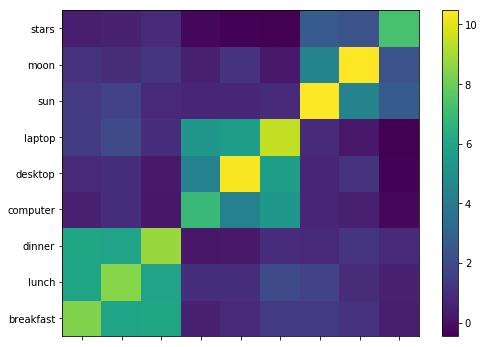

In [16]:
import numpy as np

# words = [str(i) for i in range(9)]
# words = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth', 'eleventh', 'twelfth']
# words = ['January','February','March','April','May','June','July','August','September','October','November','December']
# words = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
words = ['breakfast', 'lunch', 'dinner',
        'computer', 'desktop', 'laptop',
        'sun', 'moon', 'stars']
vectors = [model[word] for word in words]
similar = [np.dot(vectors, vector) for vector in vectors]

plt.figure(figsize=(8, 6))
plt.pcolor(np.array(similar), cmap='viridis')
plt.colorbar()
plt.yticks(0.5 + np.arange(len(words)), words)
plt.xticks(0.5 + np.arange(len(words)), '' * len(words))
plt.show()

Another idea is to find a path from one word to another. Instead of doing a linear interpolation from one vector to another, we need to do a high-dimensional spherical interpolation. This example uses code from [Transorthogonal Linguistics](https://github.com/thoppe/transorthogonal-linguistics/blob/master/transorthogonal_linguistics/slerp_word_path.py). They do some extra filtering to get better results, and you can test it [here](http://transorthogonal-linguistics.herokuapp.com/TOL/boy/man).

In [19]:
from gensim import matutils

def slerp(low, high, val):
    if val <= 0:
        return low
    elif val >= 1:
        return high
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

def slerp_steps(low, high, steps):
    return [slerp(low, high, t) for t in np.linspace(0, 1, steps)]

def print_path(start, end, steps=10, limit=100000, topn=10):
    x0 = model[start]
    x1 = model[end]
    all_words = [start, end]
    between = slerp_steps(x0, x1, steps)
    limited = model.syn0norm if limit is None else model.syn0norm[:limit]
    for x in between:
        sims = np.dot(limited, matutils.unitvec(x))
        best = matutils.argsort(sims, topn=topn, reverse=True)
        print ' '.join([model.index2word[i] for i in best if not model.index2word[i] in all_words])

In [20]:
print_path('newborn', 'elder')

baby newborn_baby infant newborns babies child newborn_babies toddler triplets
baby infant newborn_baby newborns babies child toddler newborn_babies triplets
baby infant newborn_baby newborns child babies toddler newborn_babies triplets
infant baby newborn_baby child newborns babies toddler mother triplets
infant baby child newborn_baby newborns mother toddler son
infant baby child mother son father grandchild daughter
mother infant father child son baby grandchild eldest
father mother son eldest uncle grandson child siblings aunt
father uncle eldest son elders mother grandfather grandson aunt
uncle father eldest elders grandfather maternal_grandfather nephew brother aunt


If you have a set of words you can sort them so that the path from one word to the next is always similar. This can be done with a traveling salesperson solver, like [this one in Python](https://github.com/dmishin/tsp-solver) or [this one from Google](https://developers.google.com/optimization/routing/tsp?hl=en). Here's a [list of moods](https://gist.github.com/kylemcdonald/e425243c41b2c41de5ba) sorted by a traveling salesperson solver their word2vec vector distance: `...fearless courageous brave daring bold framed blank fake phony inflated manipulated...`

We can also use PCA or t-SNE to plot a collection of word2vec vectors in 2d. Let's see if there is a principle axis that the "capital city" relationship exists along.

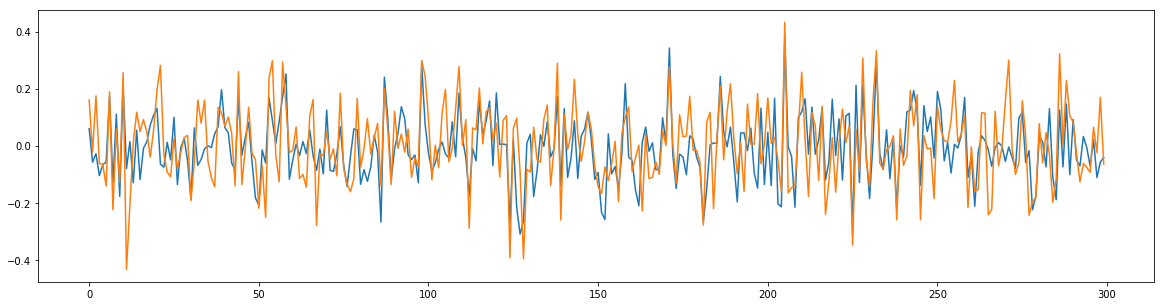

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(model['China']-model['Beijing'])
plt.plot(model['Japan']-model['Tokyo'])
# plt.plot(model['man']-model['woman'])
plt.show()

In [22]:
pairs = [
    'China', 'Beijing',
    'Japan', 'Tokyo',
    'Russia', 'Moscow',
    'South_Korea', 'Seoul',
    'Indonesia', 'Jakarta',
    'United_Kingdom', 'London',
    'Peru', 'Lima',
    'Thailand', 'Bangkok',
    'Iran', 'Tehran',
    'Egypt', 'Cairo']
# pairs = [
#     'eyes', 'glasses',
#     'hand', 'pencil',
#     'head', 'hat',
#     'feet', 'shoes',
#     'legs', 'pants']
pairs_vectors = [model[pair] for pair in pairs]

In [23]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pairs_pca = pca.fit_transform(pairs_vectors)

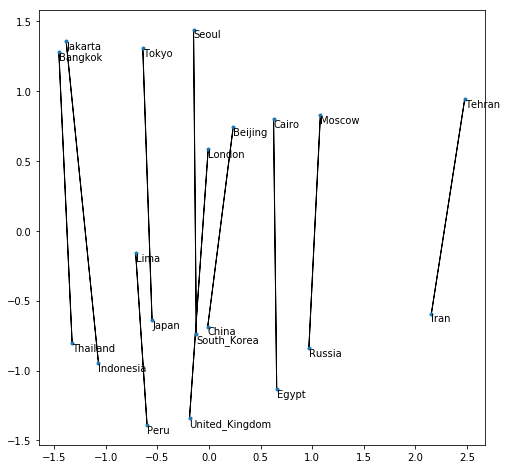

In [24]:
plt.figure(figsize=(8,8))
plt.plot(pairs_pca[:,0], pairs_pca[:,1], '.')
pair_pts = zip(pairs_pca[::2], pairs_pca[1::2])
pair_names = zip(pairs[::2], pairs[1::2])
for pt_pair, name_pair in zip(pair_pts, pair_names):
    pt0, pt1 = pt_pair
    plt.arrow(pt0[0], pt0[1], pt1[0]-pt0[0], pt1[1]-pt0[1])
    name0, name1 = name_pair
    plt.annotate(name0, pt0, va='top')
    plt.annotate(name1, pt1, va='top')
plt.show()

If you look at the relationship between a bunch of countries, you'll see the most related countries ending up next to each other. _Note: Some Countries are missing because they're not in word2vec._ For more words check out [corpora](https://github.com/dariusk/corpora).

In [25]:
words = []
with open('animals.txt') as f:
    words = [line.strip() for line in f]
print(len(words))
print(', '.join(words))

133
aardvark, alligator, alpaca, antelope, ape, armadillo, baboon, badger, bat, bear, beaver, bison, boar, buffalo, bull, camel, canary, capybara, cat, chameleon, cheetah, chimpanzee, chinchilla, chipmunk, cougar, cow, coyote, crocodile, crow, deer, dingo, dog, donkey, dromedary, elephant, elk, ewe, ferret, finch, fish, fox, frog, gazelle, gila_monster, giraffe, gnu, goat, gopher, gorilla, grizzly_bear, groundhog, guinea_pig, hamster, hedgehog, hippopotamus, hog, horse, hyena, ibex, iguana, impala, jackal, jaguar, kangaroo, koala, lamb, lemur, leopard, lion, lizard, llama, lynx, mandrill, marmoset, mink, mole, mongoose, monkey, moose, mountain_goat, mouse, mule, muskrat, mustang, mynah_bird, newt, ocelot, opossum, orangutan, oryx, otter, ox, panda, panther, parakeet, parrot, pig, platypus, polar_bear, porcupine, porpoise, prairie_dog, puma, rabbit, raccoon, ram, rat, reindeer, reptile, rhinoceros, salamander, seal, sheep, shrew, skunk, sloth, snake, squirrel, tapir, tiger, toad, turtle

We need to replace ' ' with '_' in the phrases, and ignore any words/phrases that don't appear in word2vec.

In [26]:
words_vectors = []
for word in words:
    try:
        token = word.replace(' ', '_')
        words_vectors.append(model[token])
    except KeyError:
        print 'Ignoring "' + word + '"'
print('Using {} out of {}'.format(len(words_vectors), len(words)))

Using 133 out of 133


In [30]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2)
data = np.array(words_vectors, dtype=np.float64)
%time words_tsne = tsne.fit_transform(data)

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 283 ms


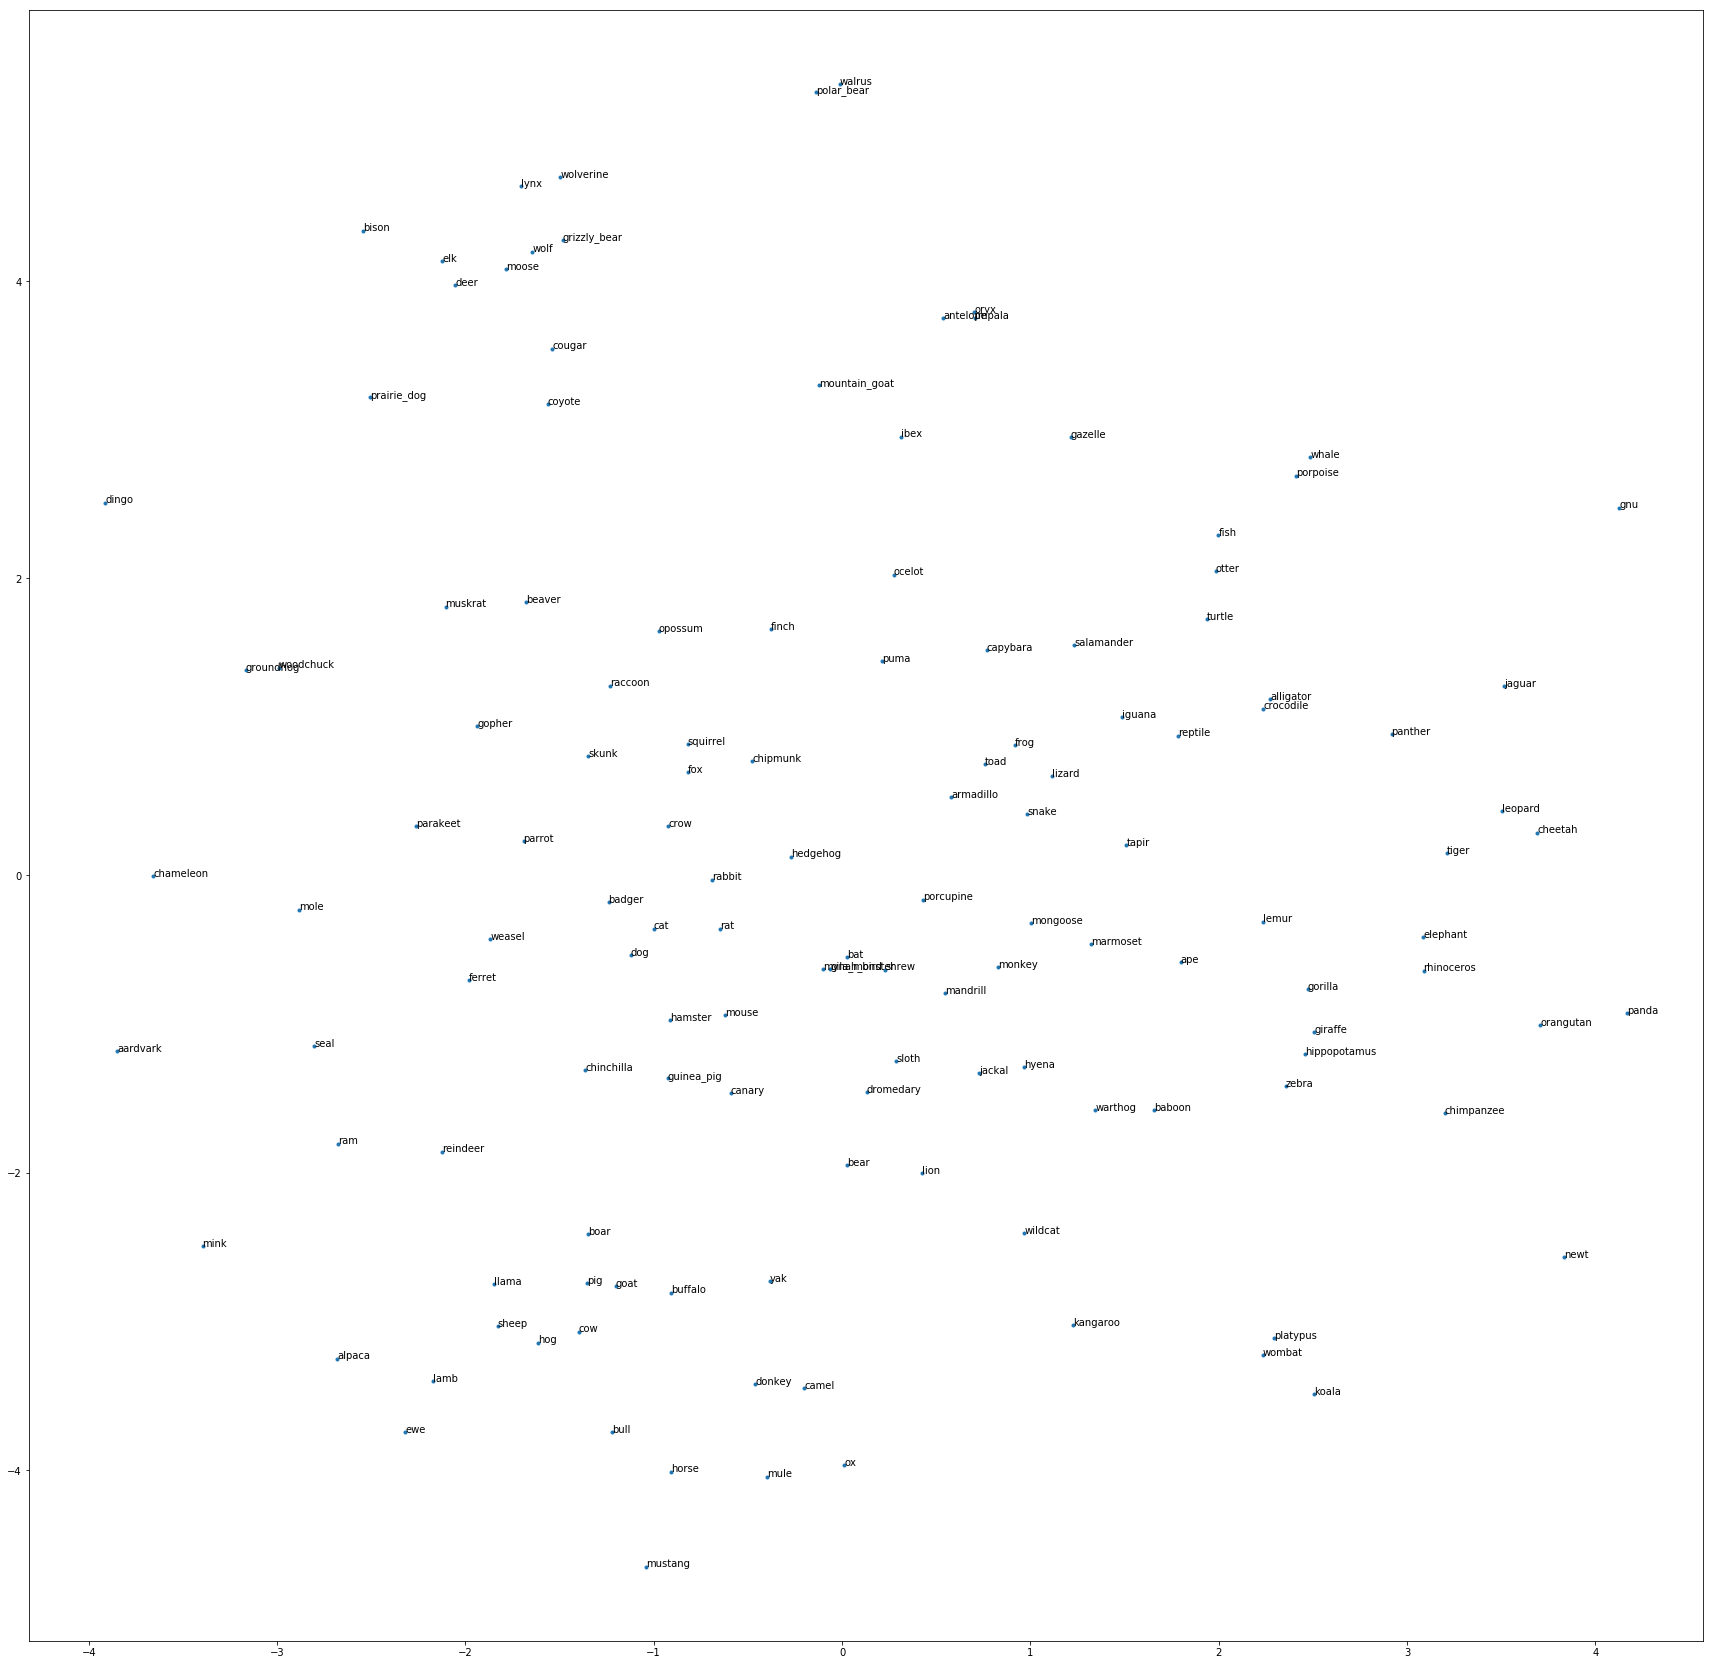

In [31]:
plt.figure(figsize=(30,30))
plt.plot(words_tsne[:,0], words_tsne[:,1], '.')
for pt, name in zip(words_tsne, words):
    plt.annotate(name, pt)
plt.show()